In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from safetensors import safe_open

In [5]:
seqs = ["gfp", "cytc", "kaib", "pd1"]
blast = {}
no_search = {}

# experiments/influence-power-law/analyses/facebook/esm2_t33_650M_UR50D
for seq in seqs:
    with safe_open(
        f"analyses/facebook/esm2_t33_650M_UR50D/scores_{seq}_{seq}/pairwise_scores.safetensors",
        "pt"
    ) as f:
        for k in f.keys():
            blast[seq] = f.get_tensor(name=k)
    with safe_open(
        f"analyses/facebook/esm2_t33_650M_UR50D/scores_uniref50_random_10k_{seq}/pairwise_scores.safetensors",
        "pt"
    ) as f:
        for k in f.keys():
            no_search[seq] = f.get_tensor(name=k)

In [43]:
def compute_alpha(top_1_percent):
    n_top_1 = len(top_1_percent)
    # cdf: y = 1 - (x / x_min) ** -alpha
    # 1-y = (x / x_min) ** -alpha
    # log(1-y) = -alpha * log(x / x_min)
    # fit MLE to the above equation
    log_y = np.log(1-np.linspace(0.99, 1, n_top_1, endpoint=False))
    log_y_mean = log_y.mean()
    log_x = np.log(top_1_percent) - np.log(top_1_percent.min())
    log_x_mean = log_x.mean()
    alpha = -np.sum((log_x - log_x_mean) * (log_y - log_y_mean)) / np.sum((log_x - log_x_mean) ** 2)
    return alpha

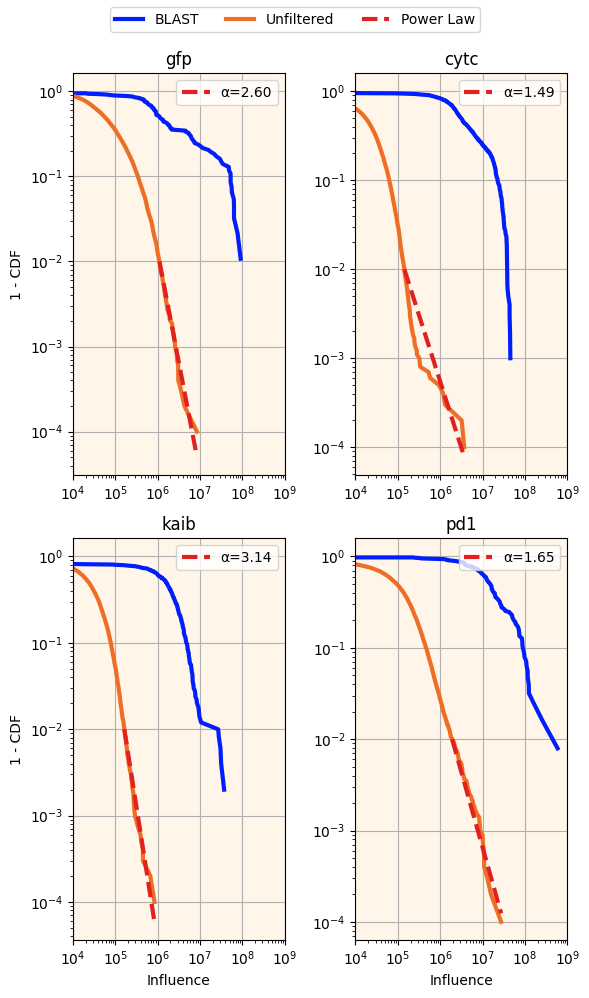

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(6, 10))
axs = axs.flatten()

for i, seq in enumerate(seqs):
    ax = axs[i]
    # add grid to plot

    # plot 1-cdf of blast scores
    blast_scores_sorted = np.sort(blast[seq].numpy().flatten())
    complementary_cdf = 1-np.linspace(0, 1, len(blast_scores_sorted), endpoint=False)
    ax.plot(blast_scores_sorted, complementary_cdf, label="BLAST", color="#011FFD", linewidth=3)
    # E12020

    # plot 1-cdf of no search scores
    no_search_scores_sorted = np.sort(no_search[seq].numpy().flatten())
    complementary_cdf = 1-np.linspace(0, 1, len(no_search_scores_sorted), endpoint=False)
    ax.plot(no_search_scores_sorted, complementary_cdf, label="Unfiltered", color="#EE6E26", linewidth=3)

    # plot unfiltered power law fit
    n = len(no_search_scores_sorted)
    top_1_percent = no_search_scores_sorted[int(n*0.99):]
    alpha = compute_alpha(top_1_percent)
    m = top_1_percent[0]
    v = np.exp(np.log(0.01)-alpha * (np.log(top_1_percent[-1]/m) - np.log(top_1_percent[0]/m)))
    if not np.isnan(alpha):
        ax.plot((top_1_percent[0], top_1_percent[-1]), (0.01, v), label=f"α={alpha:.2f}", color="#E12020", linestyle="--", linewidth=3)

    # make legend for the axis only for the power law
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[2:], labels[2:], loc='upper right')

    # label y axis of 1st column
    if i in [0, 2]:
        ax.set_ylabel("1 - CDF")
    # label x axis of 2nd row
    if i in [2, 3]:
        ax.set_xlabel("Influence")

    ax.set_title(seq)
    ax.set_facecolor("#FFF5E9")
    ax.loglog()
    # set grid every 2 orders of magnitude
    ax.grid()
    ax.set_xlim(1e4, 1e9)

handles, labels = axs[0].get_legend_handles_labels()
labels[2] = "Power Law"
fig.legend(handles, labels, loc='upper center', ncol=3)
plt.tight_layout()
plt.subplots_adjust(top=0.93)